In [ ]:
import cv2
import numpy as np
import glob
import os
import argparse

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom

In [ ]:
def gen_pluie(img, seuil=10, longueur_pluie=10, angle_pluie=0, largeur_pluie=1, alpha = 0.8):
    #génère matrice bruit initiale avec une distribution uniforme
    noise = np.random.uniform(0, 256, img.shape[0:2])

    #On garde que les valeurs supérieure a 256-seuil, les autres sont mises à zéros
    seuil = seuil * 0.01
    noise[np.where(noise < (256 - seuil))] = 0

    #on utilise un filtre afin de flouter les pixels initiaux de pluie
    k = np.array([[0, 0.1, 0],
                  [0.1, 8, 0.1],
                  [0, 0.1, 0]])

    noise = cv2.filter2D(noise, -1, k)

    #on génère la matrice représentant un trait de pluie suivant les critère longeur_pluie, angle_pluie
    trans = cv2.getRotationMatrix2D((longueur_pluie / 2, longueur_pluie / 2), angle_pluie - 45, 1 - longueur_pluie / 100.0)
    #on crée notre matrice diagonale qui représente notre "trait" de pluie
    dig = np.diag(np.ones(longueur_pluie))
    #on lui applique la transformation affine avec la matrice de rotation crée juste avant afin d'avoir la bonne longueur et le bon angle
    k = cv2.warpAffine(dig, trans, (longueur_pluie, longueur_pluie))
    #on ajoute du flou afin que la pluie soit plus "épaisse"
    k = cv2.GaussianBlur(k, (largeur_pluie,largeur_pluie), 0)
    flou = cv2.filter2D(noise, -1, k)
    cv2.normalize(flou, flou, 0, 255, cv2.NORM_MINMAX)
    filtre_pluie = np.array(flou, dtype=np.float32)



    #filtre_pluie = np.expand_dims(filtre_pluie, 2)
    #filtre_pluie = np.array(filtre_pluie, dtype=np.float32)

    img_bruitee = img.copy()

    img_bruitee[:,:] = img_bruitee[:,:] + (filtre_pluie[:,:])/255

    return img_bruitee


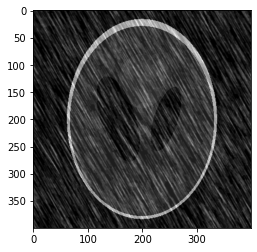

In [53]:
img = shepp_logan_phantom();


seuil = 500
longueur_pluie = 50 #10 - 60
angle_pluie = 30
largeur_pluie = 3
alpha = 0.9

img.shape
img_bruitee = gen_pluie(img, seuil, longueur_pluie, angle_pluie, largeur_pluie, alpha)
plt.imshow(img_bruitee,cmap='gray')